# Résultats des analyses sur Annonceur1_campagne3_visite_2pages

Nous présentons ici les résultats graphiques et leur analyse pour la campagne mentionnée.

In [1]:
import pandas as pd
from premiere_analyse import *
from testZ import *
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.stattools as sto
import seaborn as sns

sns.set_style("white")

import numpy as np
import scipy.stats as st
%load_ext autoreload
%autoreload 2

In [2]:
#données de la campagne
# folder = 'C:/Users/Admin/Documents/Centrale Paris/3A/OMA/Projet/Donnees/'
folder = 'Data/'
annonceur = 'annonceur1/annonceur1'
campagne = 'annonceur1_campaign3_visite_2pages'
data = pd.read_hdf(folder + annonceur + '.hdf', key=campagne)

Analyse du taux de conversion des versions A et B de la bannière en tant que série temporelle

In [3]:
#préparation des données
dataA, dataB = preparer(data) 

Conversion des index en dates
Moyennes des taux par jour et séparation en deux groupes A et B


La moyenne du taux de conversion global pour les 2 groupes est très similaire :

In [4]:
data.groupby('group')['is_conv'].mean()

group
A    0.000096
B    0.000093
Name: is_conv, dtype: float64

# Visualisation des données brutes

Est-ce qu'il y a un pattern (journalier, hebdomadaire, mensuel, ...) dans le taux de conversion ou la différence relative de taux de conversion ? 

On ajoutera aussi le nombre total de conversions pour la fréquence donnée afin de savoir si une importante différence relative est significative ou pas (si c'est 100% mais pour un 1 vs 2 par exemple).

In [5]:
freq_list = ["1D", "1W"]

conv_rate = {}
pct_change = {}
conv_count = {}

for freq in freq_list:
    conv_count[freq] = conversion_count_resample(data, freq)
    conv_rate[freq] = conversion_rate_resample(data, freq)
    pct_change[freq] = (conv_rate[freq]["A"] - conv_rate[freq]["B"]) / conv_rate[freq]["B"]
    # attention il y a des NaN quand il y a pas de conversion du groupe B

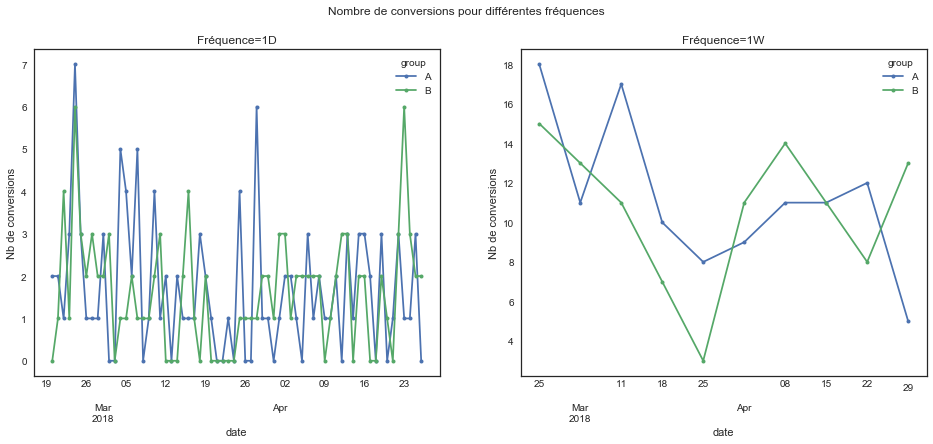

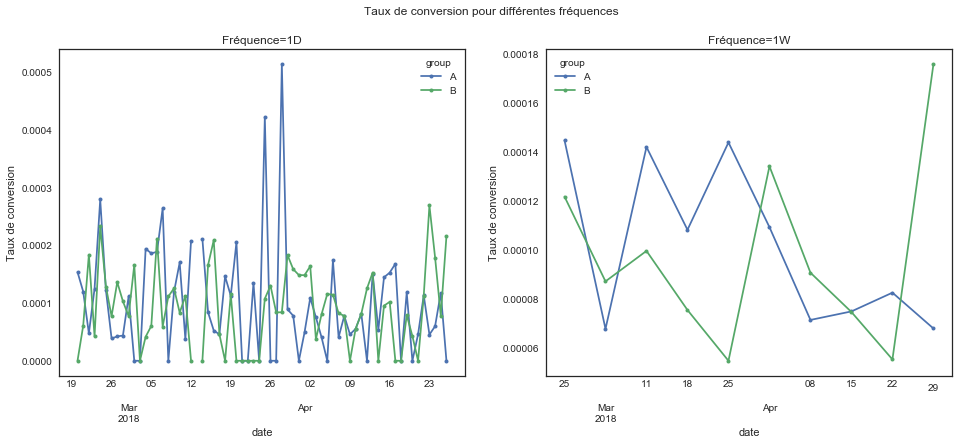

In [6]:
# trace des taux de conversion pour frequences differentes
plt.figure(figsize=(16, 6))
for i, freq in enumerate(freq_list):
    plt.subplot(1, len(freq_list), i+1)
    conv_count[freq].plot(ax=plt.gca(), marker="o", ms=4)
    plt.title(f"Fréquence={freq}")
    plt.ylabel('Nb de conversions')
plt.suptitle('Nombre de conversions pour différentes fréquences')
plt.show()

# trace des taux de conversion pour frequences differentes
plt.figure(figsize=(16, 6))
for i, freq in enumerate(freq_list):
    plt.subplot(1, len(freq_list), i+1)
    conv_rate[freq].plot(ax=plt.gca(), marker="o", ms=4)
    plt.title(f"Fréquence={freq}")
    plt.ylabel('Taux de conversion')
plt.suptitle('Taux de conversion pour différentes fréquences')
plt.show()

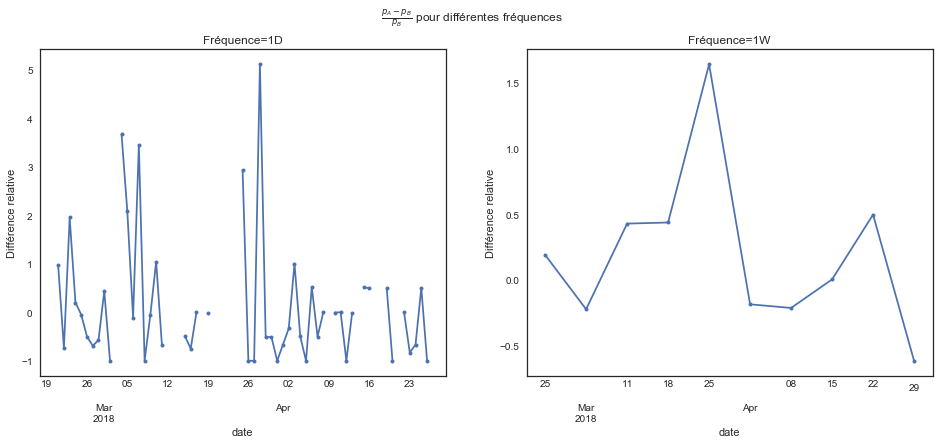

In [7]:
# trace des variations relatives pour frequences differentes
plt.figure(figsize=(16, 6))
for i, freq in enumerate(freq_list):
    plt.subplot(1, len(freq_list), i+1)
    pct_change[freq].plot(ax=plt.gca(), marker="o", ms=4)
    plt.title(f"Fréquence={freq}")
    plt.ylabel('Différence relative')
plt.suptitle('$\\frac{p_A - p_B}{p_B}$ pour différentes fréquences')
plt.show()

Dans l'ensemble il n'y a pas de tendance marquante permettant de distinguer le groupe A du groupe B quel que soit l'échelle considérée pour ce dataset. La différence relative est difficilement exploitable car les taux de conversion peuvent valoir 0 pour les deux groupes.

En revanche, le changement de fréquence permet un lissage des données avec moins de variance mais le nombre de données devient très faible. Peut-être considérer un lissage sur une période glissante de 3 à 5 jours ?

# Test Z

## Test Z global

Enfin, on conduit un Z-test destiné à mesurer l'efficacité statistique du test A/B mené. Mathématiquement, cela se traduit par la comparaison de l'hypothèse nulle H0 : "le taux de conversion sous version A est le même que celui sous version B" avec l'hypothèse H1 : "le taux de conversion sous version A est différent que celui sous version B". 

Pour ce faire, on utilise l'**ensemble des données** (du début jusqu'à la fin de la campagne) du dataset pour réaliser le test qui nous donnera une statistique qui nous permettra de calculer la p-valeur i.e. la probabilité de rejeter l'hypothèse nulle H0, à l'issue de toute la durée de la campagne.

In [8]:
Z, Prej = testZ(data)
print('Zstat = {0:.3}, Pval={1:.3}'.format(Z, Prej))

Zstat = 0.254, Pval=0.8


La Pval étant de 0.8, on ne peut donc pas rejeter l'hypothèse nulle avec un seuil de confiance classique (5%, 1%).

Conclusion : à l'issue toute la campagne, aucune des deux versions n'est meilleure que l'autre en termes de taux de conversion journalier.

## Test Z cumulé

Est-ce que le Z-test aurait donné des résultats différents si l'on a arrêté le test A/B à des instants plus tôt ? 

On s'intéresse maintenant aux **données cumulées** : en regardant l'ensemble des informations dont on dispose du jour 1 de la campagne publicitaire au jour n, peut-on voir une certaine tendance quant au test d'hypothèses ? Est-ce que si l'on avait arrêté le test plus tôt les résultats auraient été différents ?

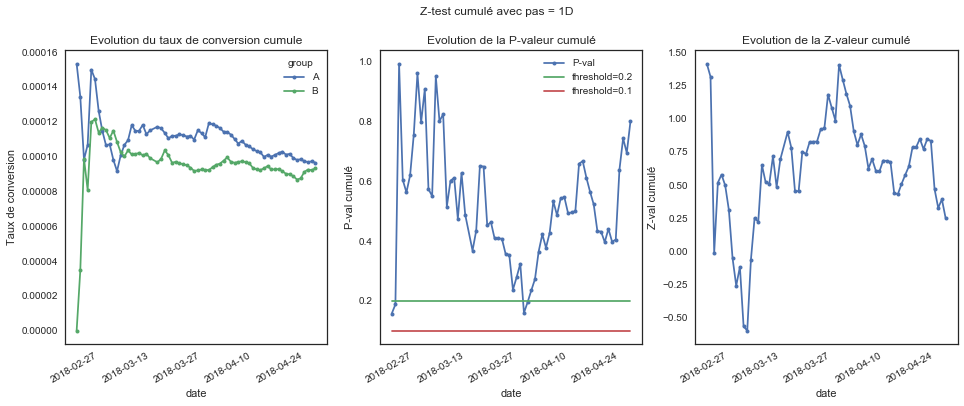

In [9]:
freq = "1D"
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq=freq)
plot_testZ_cum_frequency(Z_cum, P_rej, p_cum, freq)

Les résultats du Z test sont  différents en fonction de l'instant considéré : si on s'était arrêté vers fin Mars on aurait pu rejeter H0 avec un taux de confiance de 20% et dire que A est meilleur. Mais, dans tous les cas, on est au-dessus de la p-valeur de 10% et quasiment tout le temps au-dessus de 20% :  il n'y a pas de variation de la significativité du test et on ne peut pas conclure pour ces niveaux de confiance que les deux versions sont différentes.

Est-ce que la réalisation du testZ cumulé avec un pas de plusieurs jours donnerait de meilleurs résultats ? On fait un test Z avec les données de t0 à t0 + pas, puis t0 à t0 + 2pas...

/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


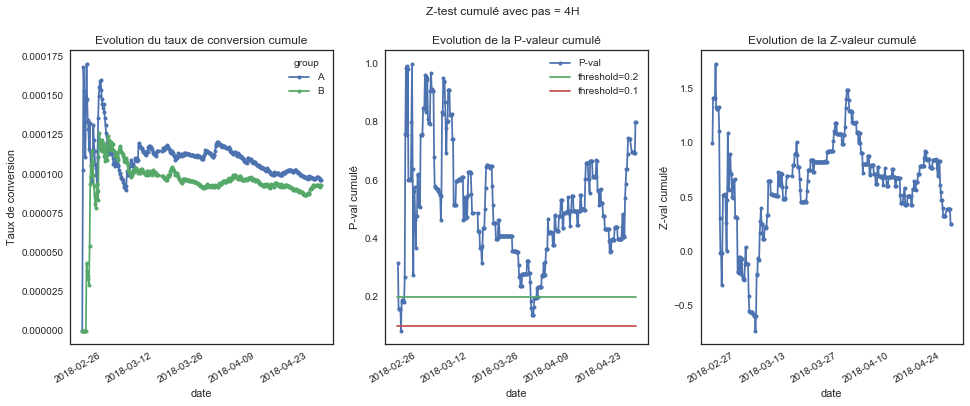

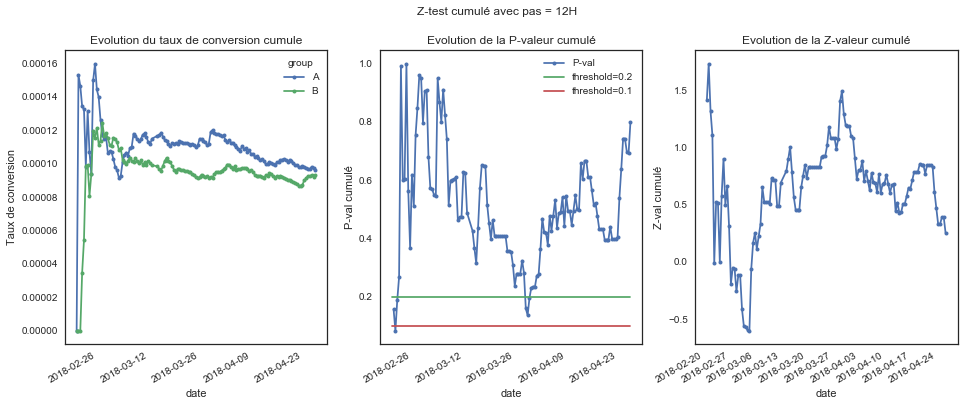

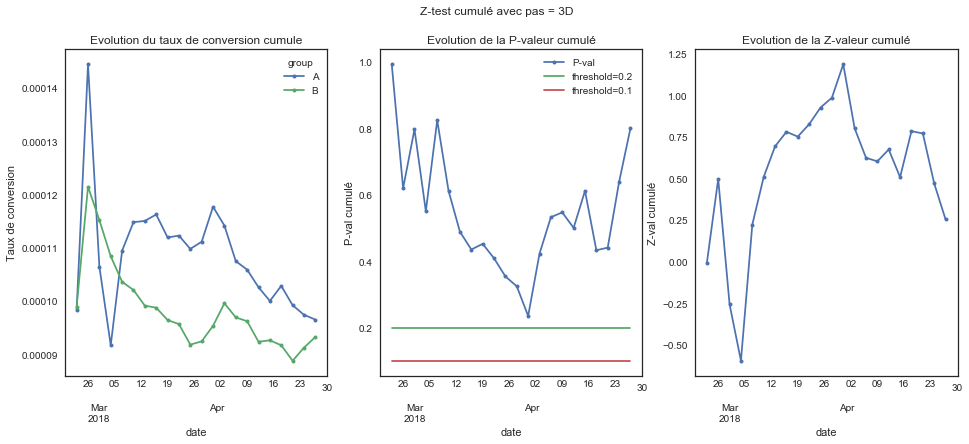

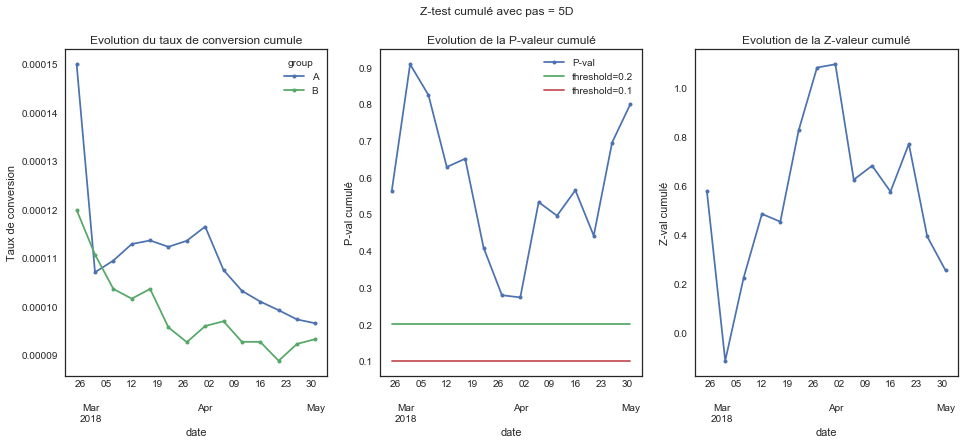

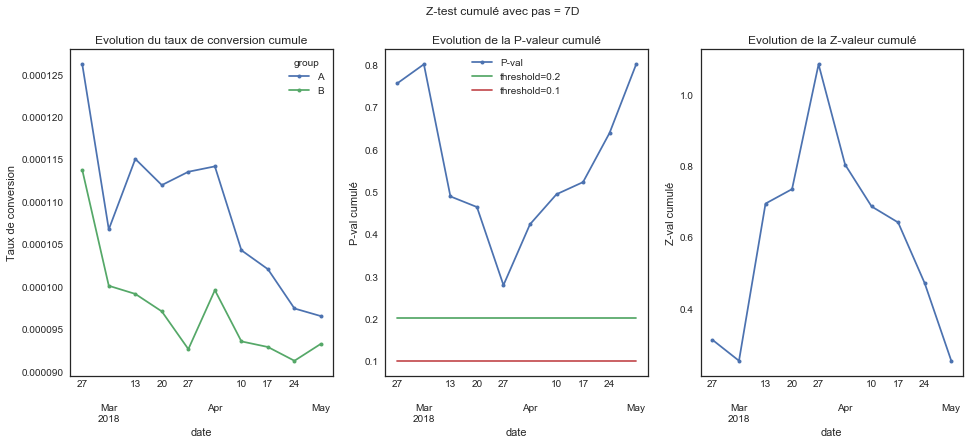

In [12]:
for freq in ["4H", "12H", "3D", "5D", "7D"]:  # 1W does not work but 7D is ok
    Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq=freq)
    plot_testZ_cum_frequency(Z_cum, P_rej, p_cum, freq)

/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


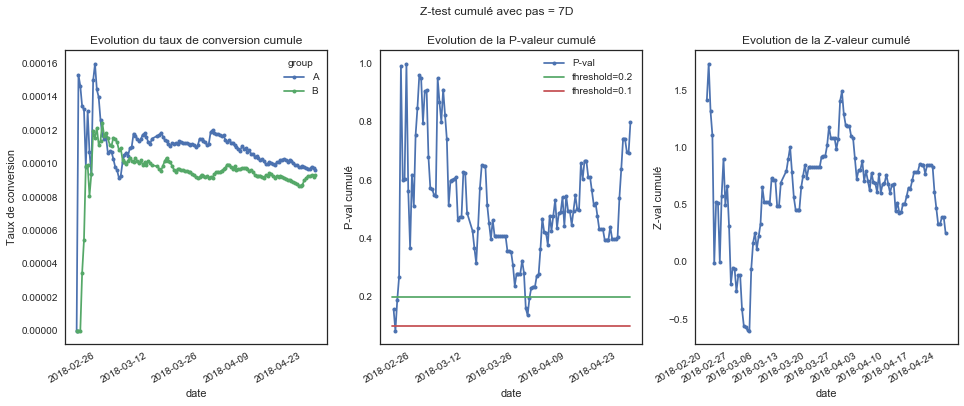

In [15]:
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq="12H")
plot_testZ_cum_frequency(Z_cum, P_rej, p_cum, freq)

Conclusion : 

Avec des pas de 4H, 12H, 3, 5 et 7 jours, la conclusion reste la même, aucune version n'est meilleure.

Il serait peut-être intéressant d'étudier la stationnarité de la série des Pval ou de la valeur Z.  

# Stationnarité des taux de conversion

## Groupe A

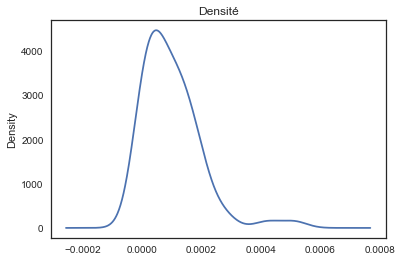

## Analyse classique d'une ST

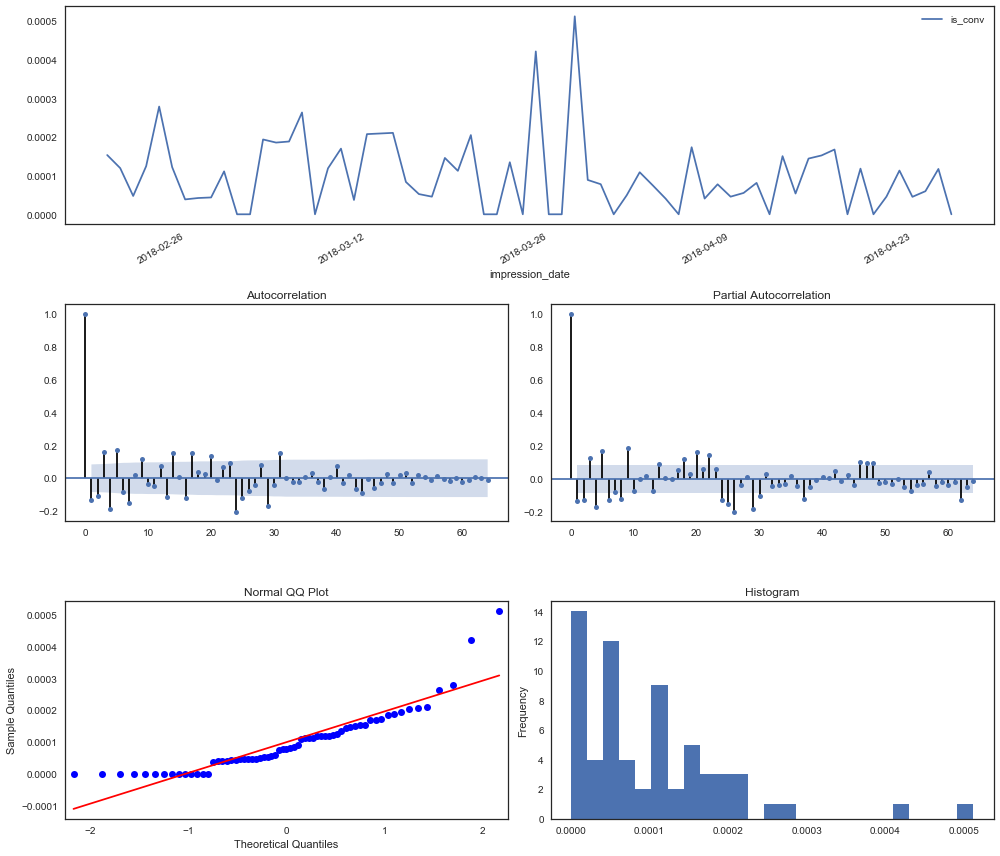

## Effet journalier

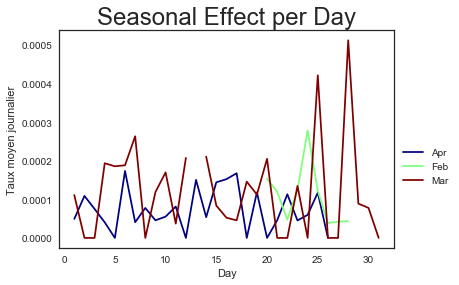

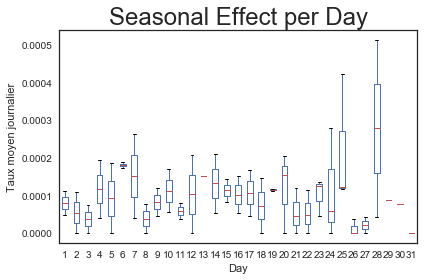

## Décomposition de la série de temps selon modèle multiplicatif



Multiplicative seasonality is not appropriate for zero and negative values


## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-8.966872e+00
p-value,7.945456e-15
# of lags,0.000000e+00
# of observations,6.400000e+01
Critical Value (1%),-3.536928e+00
Critical Value (5%),-2.907887e+00
Critical Value (10%),-2.591493e+00


In [4]:
analyser(dataA)

Différencier à l'ordre 1: y_t - y_[t-1]
Analyse après transformation



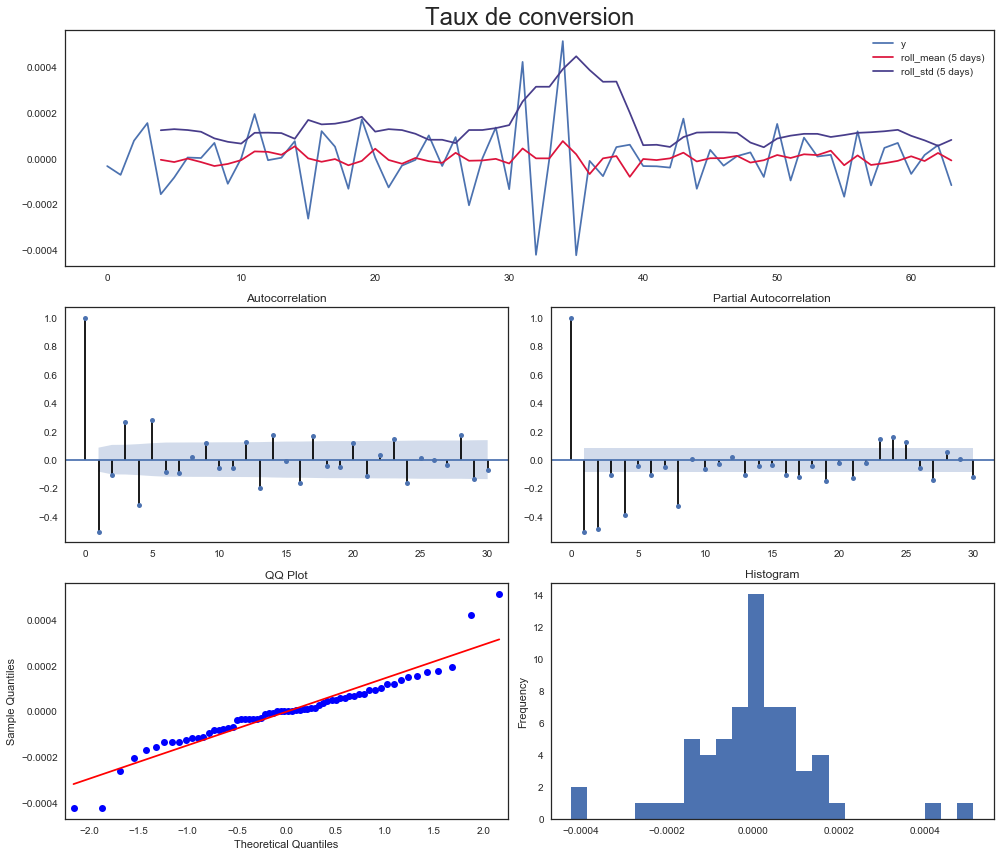

,Results of Augmented Dickey-Fuller test:
test statistic,-7.740512e+00
p-value,1.065030e-11
# of lags,3.000000e+00
# of observations,6.000000e+01
Critical Value (1%),-3.544369e+00
Critical Value (5%),-2.911073e+00
Critical Value (10%),-2.593190e+00


In [5]:
transformer(dataA,"diff1")

## Groupe B

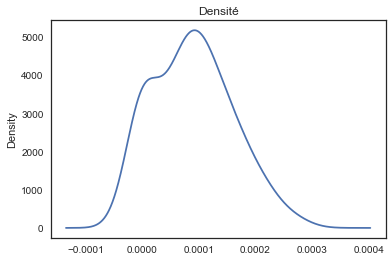

## Analyse classique d'une ST

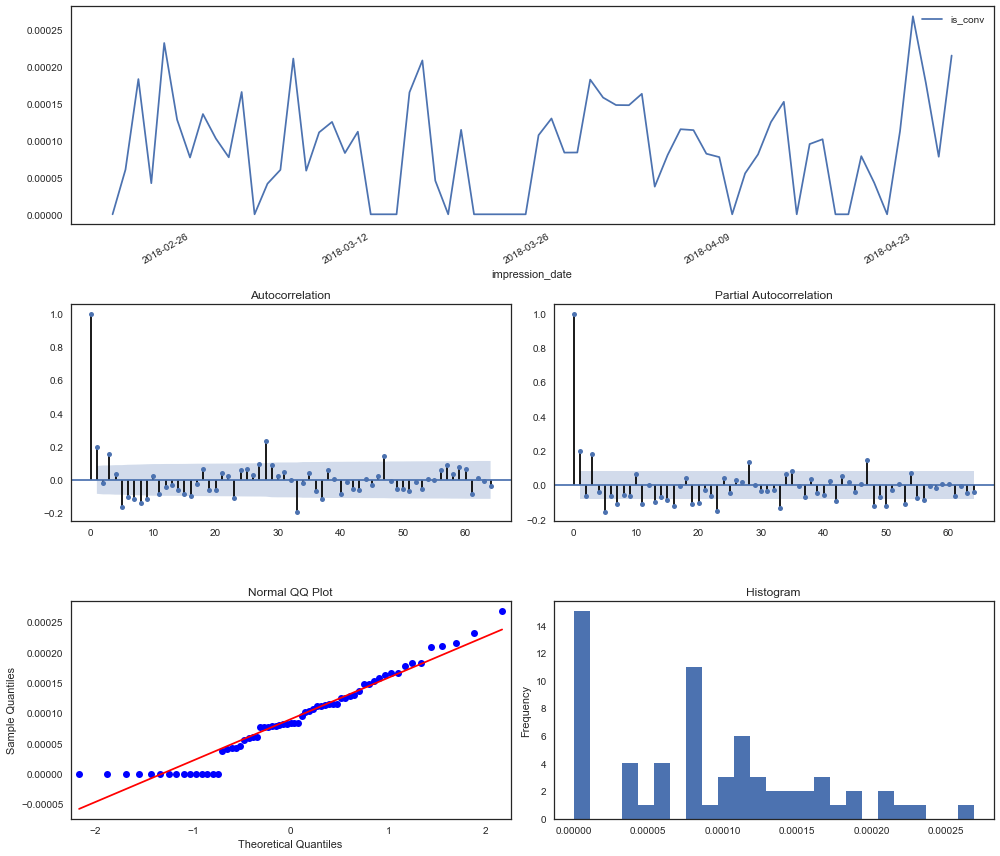

## Effet journalier

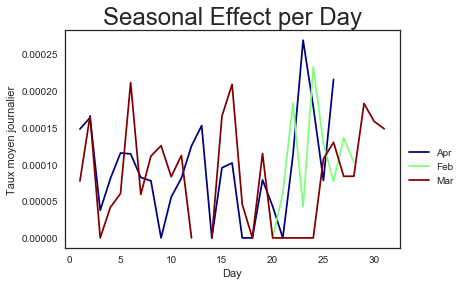

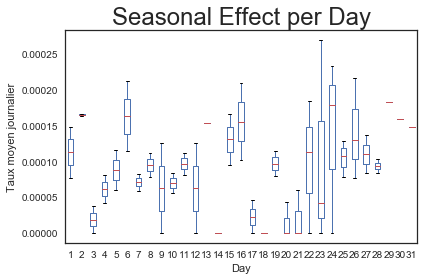

## Décomposition de la série de temps selon modèle multiplicatif



Multiplicative seasonality is not appropriate for zero and negative values


## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-3.174044
p-value,0.021537
# of lags,4.000000
# of observations,60.000000
Critical Value (1%),-3.544369
Critical Value (5%),-2.911073
Critical Value (10%),-2.593190


In [6]:
analyser(dataB)

Différencier à l'ordre 1: y_t - y_[t-1]
Analyse après transformation



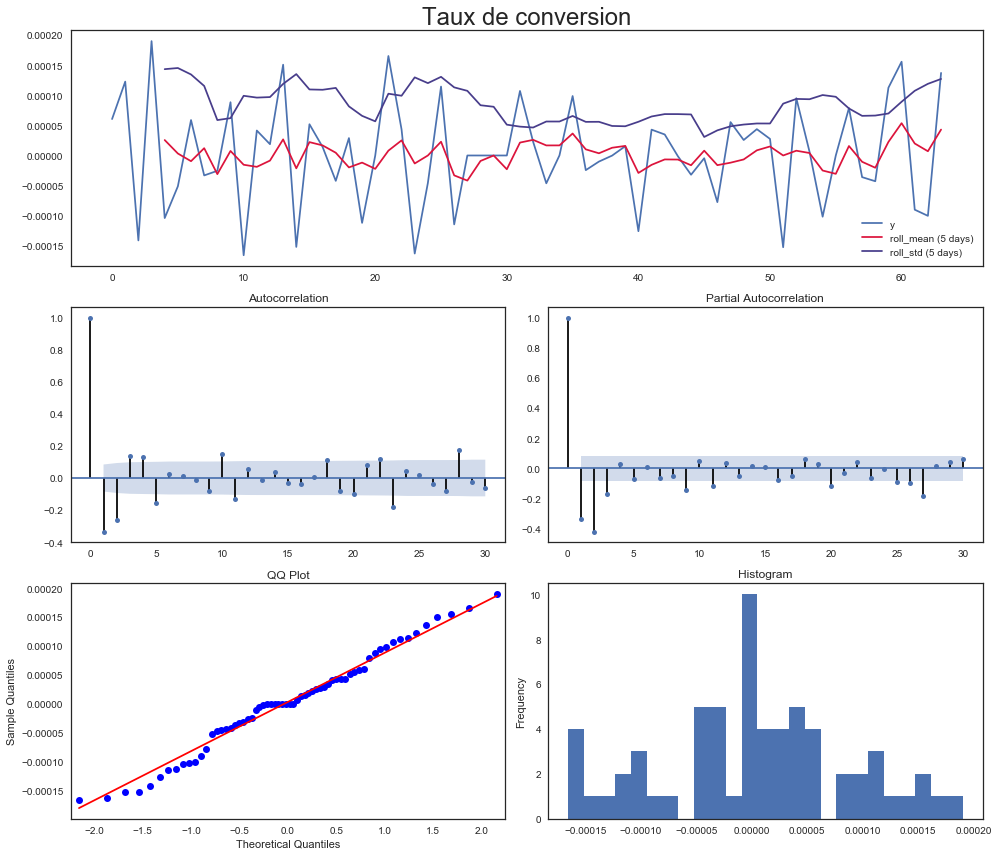

,Results of Augmented Dickey-Fuller test:
test statistic,-7.130671e+00
p-value,3.524617e-10
# of lags,2.000000e+00
# of observations,6.100000e+01
Critical Value (1%),-3.542413e+00
Critical Value (5%),-2.910236e+00
Critical Value (10%),-2.592745e+00


In [7]:
transformer(dataB,"diff1")

# Modèles ARMA

In [3]:
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq='1D')

## Analyse classique d'une ST

/anaconda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


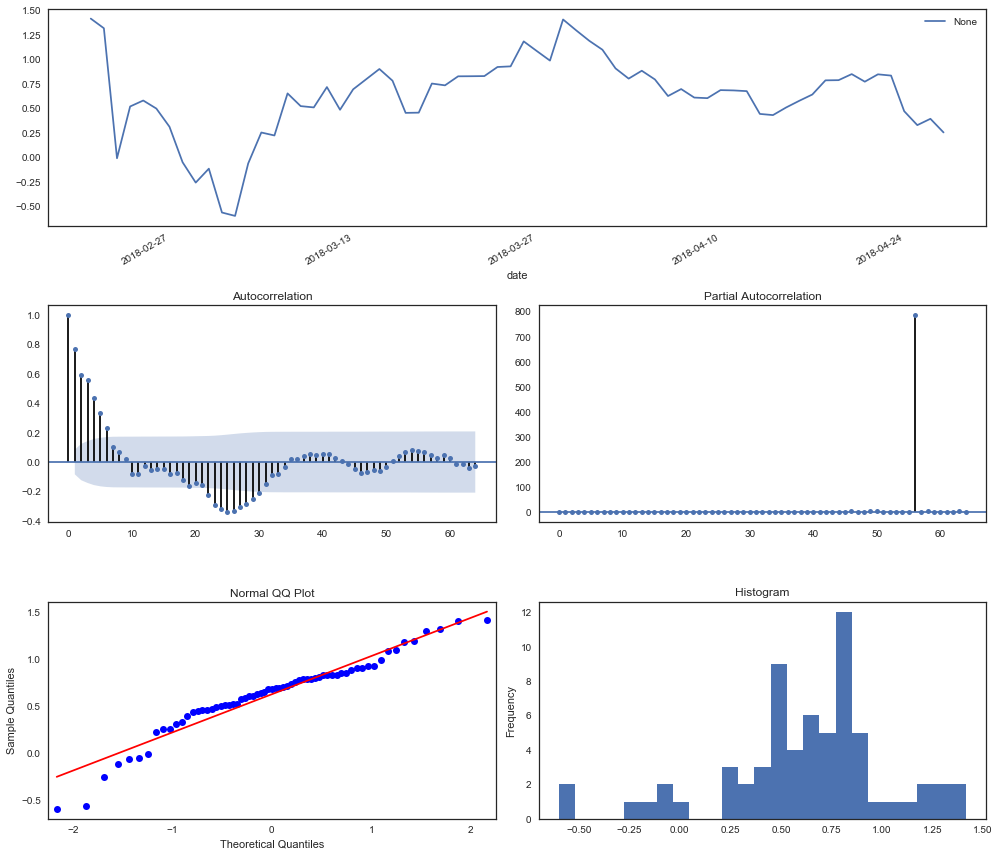

## Décomposition de la série de temps selon modèle multiplicatif



Multiplicative seasonality is not appropriate for zero and negative values


## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-2.946244
p-value,0.040229
# of lags,0.000000
# of observations,64.000000
Critical Value (1%),-3.536928
Critical Value (5%),-2.907887
Critical Value (10%),-2.591493


In [4]:
analyserZP(Z_cum)

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


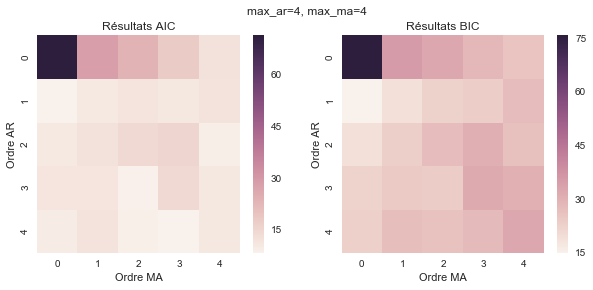

AIC meilleur modèle : AR=4, MA=3, AIC=8.165326633273764 
BIC meilleur modèle : AR=1, MA=0, BIC=14.791940670465237 


In [27]:
##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = sto.arma_order_select_ic(
    Z_cum.values,
    ic = ['aic', 'bic'],
    max_ar=max_ar, 
    max_ma=max_ma
)

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
sns.heatmap(order_select["aic"])
plt.xlabel("Ordre MA")
plt.ylabel("Ordre AR")
plt.title("Résultats AIC")

plt.subplot(1, 2, 2)
sns.heatmap(order_select["bic"])
plt.xlabel("Ordre MA")
plt.ylabel("Ordre AR")
plt.title("Résultats BIC")

plt.suptitle(f"max_ar={max_ar}, max_ma={max_ma}")
plt.show();

aic_min_order = order_select["aic_min_order"]
bic_min_order = order_select["bic_min_order"]
print(
    "AIC meilleur modèle : AR={}, MA={}, AIC={} ".format(
        aic_min_order[0], aic_min_order[1], 
        order_select['aic'].loc[aic_min_order]
    )
)
print(
    "BIC meilleur modèle : AR={}, MA={}, BIC={} ".format(
        bic_min_order[0], bic_min_order[1], 
        order_select['bic'].loc[bic_min_order]
    )
)

# Meilleur modèle selon AIC

## Fit du modèle



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   65
Model:                     ARMA(4, 3)   Log Likelihood                   4.917
Method:                       css-mle   S.D. of innovations              0.216
Date:                Wed, 23 Jan 2019   AIC                              8.165
Time:                        22:34:51   BIC                             27.735
Sample:                             0   HQIC                            15.887
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6789      0.044     15.269      0.000       0.592       0.766
ar.L1.y        0.7479      0.101      7.370      0.000       0.549       0.947
ar.L2.y        0.2146      0.121      1.778      0

## Erreurs

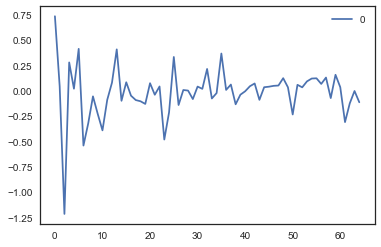

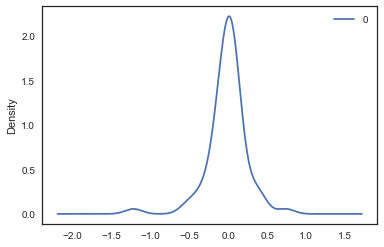

               0
count  65.000000
mean   -0.015767
std     0.251701
min    -1.217061
25%    -0.092425
50%     0.018294
75%     0.071522
max     0.735445


# Meilleur modèle selon BIC

## Fit du modèle



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   65
Model:                     ARMA(1, 0)   Log Likelihood                  -1.134
Method:                       css-mle   S.D. of innovations              0.244
Date:                Wed, 23 Jan 2019   AIC                              8.269
Time:                        22:34:51   BIC                             14.792
Sample:                             0   HQIC                            10.843
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6488      0.154      4.221      0.000       0.348       0.950
ar.L1.y        0.8146      0.074     10.977      0.000       0.669       0.960
                                    Roots         

## Erreurs

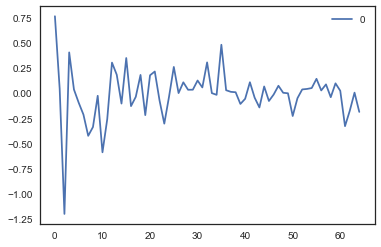

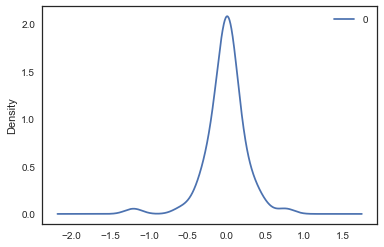

               0
count  65.000000
mean   -0.009594
std     0.257946
min    -1.201962
25%    -0.094986
50%     0.005125
75%     0.087295
max     0.765517


In [32]:
display(Markdown("# Meilleur modèle selon AIC"))
testARMA(Z_cum.values, p=aic_min_order[0], d=0, q=aic_min_order[1])

display(Markdown("# Meilleur modèle selon BIC"))
testARMA(Z_cum.values, p=bic_min_order[0], d=0, q=bic_min_order[1])

### Zoom sur un modèle en particulier

Pour un modèle donné, est-ce que ce modèle est pertinent ? Regarder les p-valeurs des coefficients. 

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   66
Model:                     ARMA(4, 3)   Log Likelihood                   0.039
Method:                       css-mle   S.D. of innovations              0.236
Date:                Wed, 23 Jan 2019   AIC                             17.922
Time:                        23:46:30   BIC                             37.628
Sample:                    02-21-2018   HQIC                            25.709
                         - 04-27-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6478      0.143      4.527      0.000       0.367       0.928
ar.L1.y        0.0400      0.434      0.092      0.927      -0.810       0.890
ar.L2.y       -0.3720      0.335     -1.111      0.2

## Erreurs

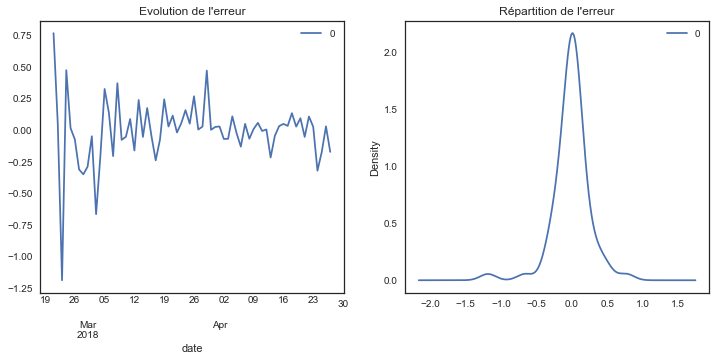

In [171]:
##################################### PARAMETRES #####################################
p = bic_min_order[0]  # AR(p)
d = 0  # d=0 pour ARMA
q = bic_min_order[1]  # MA(q)
p, q = 4, 3
######################################################################################

# asfreq permettra de faire des predictions et de les afficher facilement...
# ffill au cas ou il manque des jours... 
# mais faire très attention aux datasets où il manque une grosse plage de journées!
# genre a1c1 vers la fin... donc je mets une limite au nb max de jours manquants
assert Z_cum.asfreq("D").isna().sum() < 5

model = ARIMA(Z_cum.asfreq("D").fillna(method="ffill"), order=(p, d, q), freq="D").fit()
# model_fit = model.fit(disp=0)
print(model.summary())
# print(model_fit.summary())
display(Markdown("## Erreurs"))
print('\n')
residuals = DataFrame(model.resid)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
residuals.plot(ax=plt.gca())
plt.title("Evolution de l'erreur")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', ax=plt.gca())
plt.title("Répartition de l'erreur")

plt.show()

Dans cette section on a construit le modèle à partir de l'ensemble des données. Mais quelles sont les prévisions selon le modèle sur les données existantes (in-sample)? 
On réalise des prédictions de `pred_start` à `pred_end` (None donne la fin de la période)
On peut distinguer deux types de prévisions : 
+ 1-step-ahead : on utilise toutes les données jusqu'à J-1
+ Dynamic : à partir de pred_start on utilise les variables prédites comme entrées

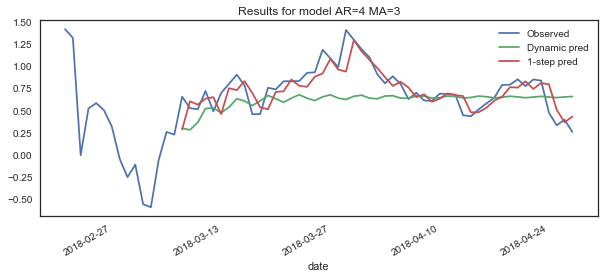

In [174]:
##################################### PARAMETRES #####################################
pred_start = 45  # debut des predictions
pred_end = 100  # fin des predictions
pred_start = 15
pred_end = None
######################################################################################

# Différence entre dynamic predictions & non-dynamic
#     The `dynamic` keyword affects in-sample prediction. If dynamic
#     is False, then the in-sample lagged values are used for
#     prediction. If `dynamic` is True, then in-sample forecasts are
#     used in place of lagged dependent variables. The first forecasted
#     value is `start`.
# Dans notre cas pred_start=len(Z_cum)+1 donne donc les 
# même résultats pour dynamic & one_step_head, la différence est uniquement au sein du in-sample

dates = Z_cum.index
dynamic_predictions = model.predict(start=pred_start, end=pred_end, dynamic=True)
one_step_ahead_predictions = model.predict(start=pred_start, end=pred_end, dynamic=False)

plt.figure(figsize=(10, 4))
Z_cum.plot(ax=plt.gca(), label="Observed")
dynamic_predictions.plot(ax=plt.gca(), label="Dynamic pred")
one_step_ahead_predictions.plot(ax=plt.gca(), label="1-step pred")
plt.legend()
plt.title(f"Results for model AR={p} MA={q}")
plt.show()

A suivre en regardant les résultats out-of-sample...